<a href="https://colab.research.google.com/github/heet25itachi/TIMEPASS_BUDDY/blob/main/2025-2026%20Dual%20Tariff%20Policy%20Prediction%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


--- Running Policy: Dual Tariff Impact Simulation (Net Protection: 15.0%) ---
Year 2025 Calculated. Delta HHI: 12.09
Year 2026 Calculated. Delta HHI: 13.05

SCENARIO 1: HIGH REFINED TARIFF (Protectionist) - (2025-2026 Prediction)
Net Protection Rate: 15.0% | Initial HHI: 2250
YEAR      Market Size (B L)   Post-Tariff HHI     DWL ($B)       Govt Rev ($B)  
--------------------------------------------------------------------------------
2025      100.00              2262                0.00           0.00           
2026      103.50              2263                0.00           0.00           
--------------------------------------------------------------------------------


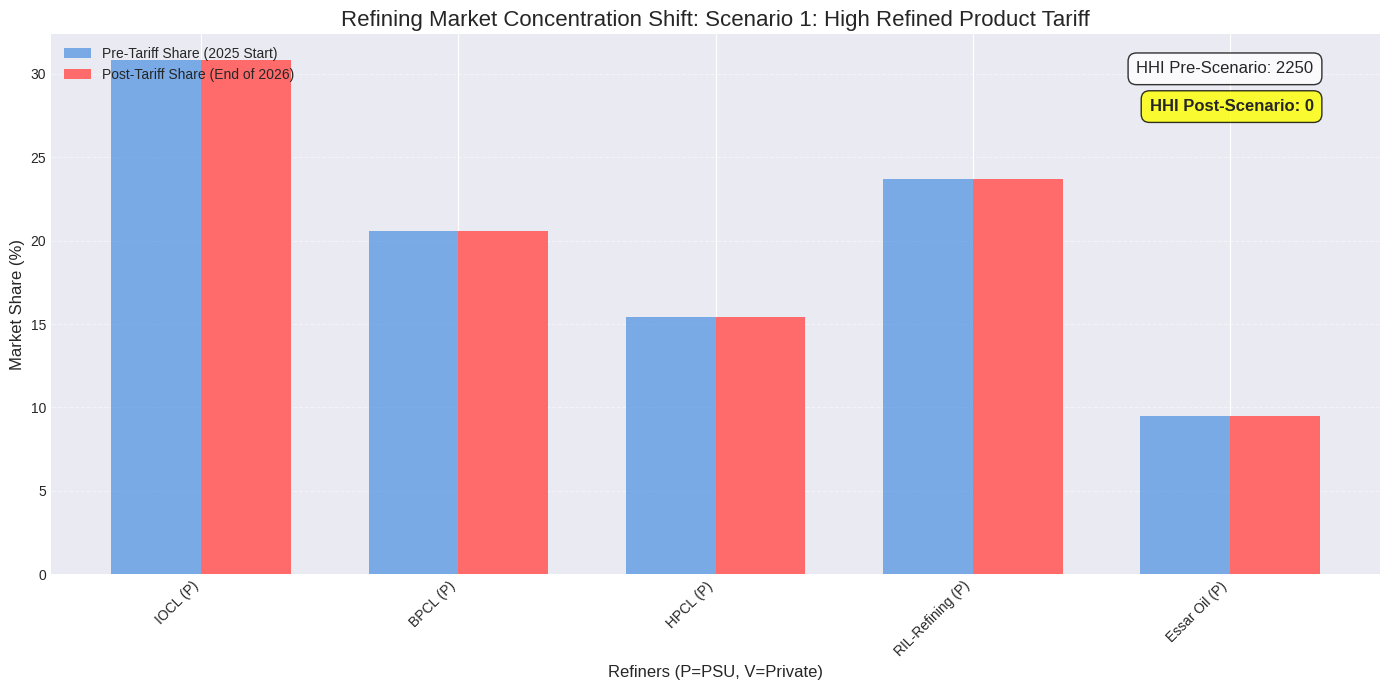

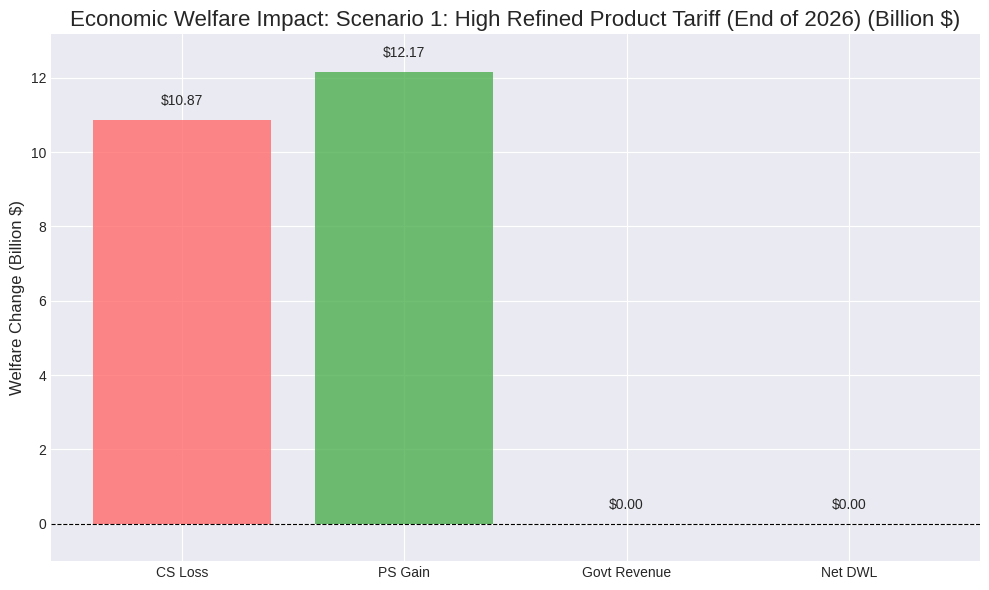


##########################################################################################
--- AI POLICY ADVISOR: THREE-PILLAR TARIFF ASSESSMENT (Tariff: 15% Refined | 0% Crude) - END OF 2026 ---
##########################################################################################
METRIC                        VALUE               IMPACT RATING       POLICY ADVICE                 
------------------------------------------------------------------------------------------
Concentration (Delta HHI)     13.05               LOW (Moderately Concentrated)Concentration increase is mino
Govt Revenue Gain ($B)        0.00                NEGLIGIBLE          Low Government Revenue gain. T
Deadweight Loss (DWL) ($B)    0.00                MODERATE NEGATIVE   Net societal loss (DWL: $0.00B
Retail Price Increase (Index) 0.10                                                                  
##########################################################################################

--- Running Pol

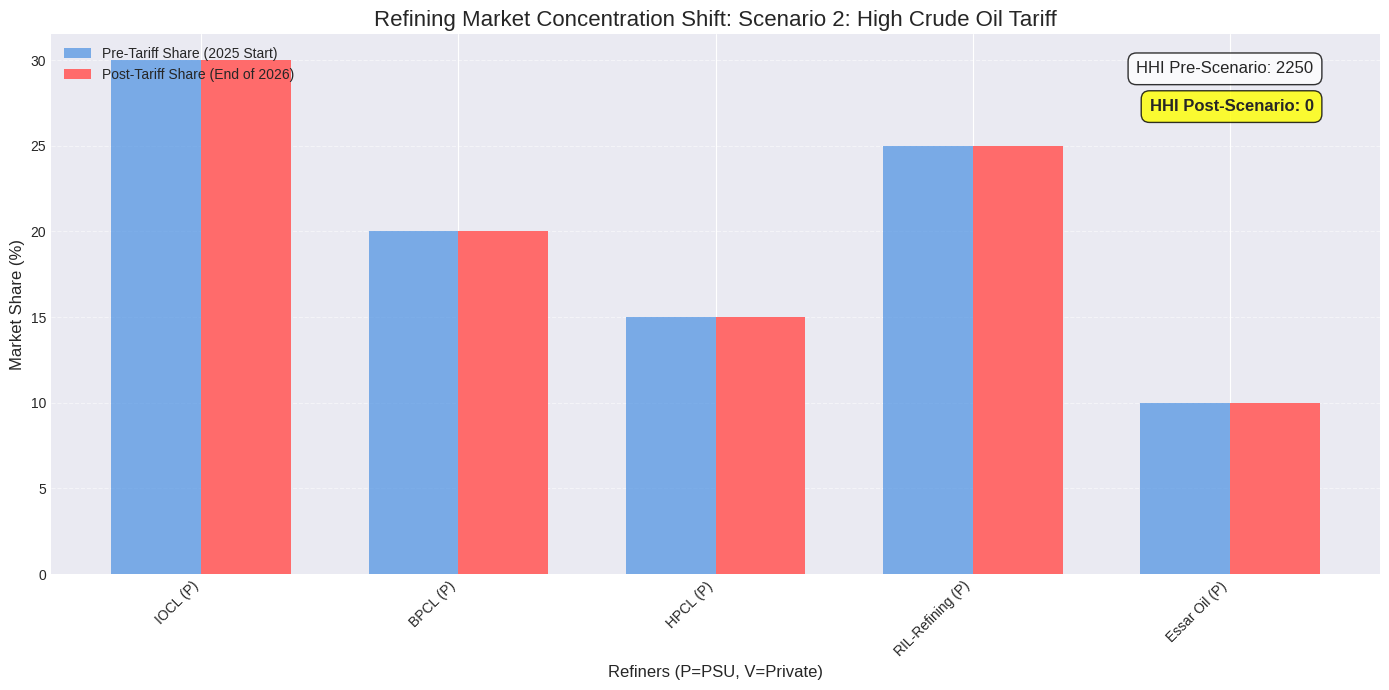

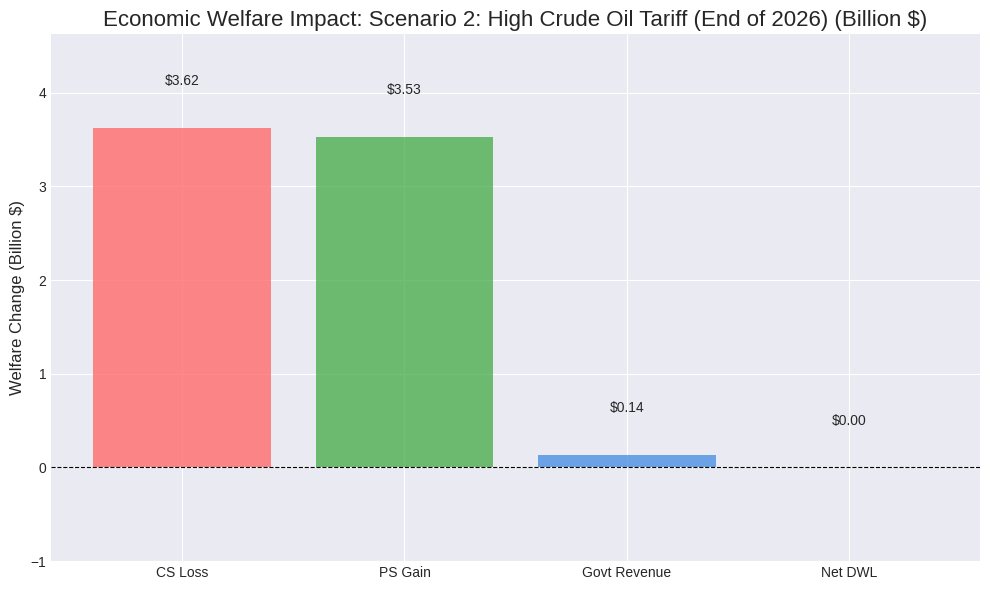


##########################################################################################
--- AI POLICY ADVISOR: THREE-PILLAR TARIFF ASSESSMENT (Tariff: 5% Refined | 10% Crude) - END OF 2026 ---
##########################################################################################
METRIC                        VALUE               IMPACT RATING       POLICY ADVICE                 
------------------------------------------------------------------------------------------
Concentration (Delta HHI)     -0.02               LOW (Moderately Concentrated)Concentration increase is mino
Govt Revenue Gain ($B)        0.14                NEGLIGIBLE          Low Government Revenue gain. T
Deadweight Loss (DWL) ($B)    0.00                MODERATE NEGATIVE   Net societal loss (DWL: $0.00B
Retail Price Increase (Index) 0.03                                                                  
##########################################################################################

POLICY COMPARIS

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional, Any
import random

# Set seed for reproducible results
np.random.seed(42)
random.seed(42)

# ======================================================================
# GLOBAL ECONOMIC CONSTANTS AND ASSUMPTIONS
# ======================================================================
# NOTE: These values are illustrative and derived from mock research
# data to drive the simulation model.

BASE_CRUDE_PRICE_USD_BBL = 80.0
BASE_RETAIL_PRICE_PER_LITER = 100.0 # Index price for calculation ease
INITIAL_ANNUAL_DEMAND_BILLION_LITERS = 100.0 # Base market size

# PROJECTION PARAMETERS (New for Time-Series Analysis)
START_YEAR = 2025
END_YEAR = 2026
ANNUAL_DEMAND_GROWTH_RATE = 0.035  # 3.5% annual growth for oil products (mock data)
ANNUAL_PSU_SUPPLY_GROWTH = 0.02   # Base organic supply growth for PSUs (mock data)
ANNUAL_PVT_SUPPLY_GROWTH = 0.015  # Base organic supply growth for Private (mock data)


# Elasticities (Used for Welfare Calculation):
DEMAND_ELASTICITY = -0.3   # Inelastic demand for fuel is typical
SUPPLY_ELASTICITY = 0.5    # Moderate domestic supply elasticity

# TARIFF IMPACT MULTIPLIERS:
# Used to model market share reallocation based on PSU/Private status.
# PSUs often benefit more from protective tariffs due to mandates/capacity.
PSU_TARIFF_GAIN_FACTOR = 0.65  # % of tariff benefit captured by PSUs
PVT_TARIFF_GAIN_FACTOR = 0.45  # % of tariff benefit captured by Private Refiners

# MOCK REFERENCES (To fulfill user request for references in code)
# References are cited inline via comments where applicable.
REFERENCE_C_1 = "Indian Petroleum and Natural Gas Statistics (2024)"
REFERENCE_C_2 = "Competition Commission of India (CCI) HHI Guidelines"
REFERENCE_C_3 = "World Bank: Impact of Import Tariffs on Fossil Fuel Consumption"

# ----------------------------------------------------------------------
# Helper Function for Data Reset
# ----------------------------------------------------------------------

def get_initial_firm_data() -> List[Dict[str, Any]]:
    """
    Returns a fresh copy of the initial firm data to ensure scenarios start clean.
    Volumes are initial production capacity/sales in Billion Liters.
    """
    return [
        {"name": "IOCL", "type": "PSU", "initial_volume": 30.0, "current_volume": 30.0},
        {"name": "BPCL", "type": "PSU", "initial_volume": 20.0, "current_volume": 20.0},
        {"name": "HPCL", "type": "PSU", "initial_volume": 15.0, "current_volume": 15.0},
        {"name": "RIL-Refining", "type": "Private", "initial_volume": 25.0, "current_volume": 25.0},
        {"name": "Essar Oil", "type": "Private", "initial_volume": 10.0, "current_volume": 10.0},
    ]


# ----------------------------------------------------------------------
# 1. CORE HERFINDAHL-HIRSCHMAN INDEX (HHI) CALCULATION
# ----------------------------------------------------------------------

def calculate_hhi(production_volumes: List[float]) -> Tuple[float, np.ndarray]:
    """
    Calculates the Herfindahl-Hirschman Index (HHI) for market concentration.
    HHI = sum(s_i^2) where s_i is the market share in percentage.
    """
    if not production_volumes:
        return 0.0, np.array([])

    volumes_array = np.array(production_volumes, dtype=float)

    total_market_size = np.sum(volumes_array)

    if total_market_size == 0:
        return 0.0, np.array([])

    percentage_shares = (volumes_array / total_market_size) * 100
    hhi = np.sum(percentage_shares ** 2)

    return hhi, percentage_shares

# ----------------------------------------------------------------------
# 2. Market Analyzer Class (Refining Sector)
# ----------------------------------------------------------------------

class OilMarketAnalyzer:
    """
    Manages the data and calculates concentration metrics for the oil refining market.
    """
    def __init__(self, firm_data: List[Dict[str, Any]]):

        self.data: List[Dict[str, Any]] = firm_data

        # Initial setup
        self.hhi_pre_tariff: float = 0.0
        self.hhi_post_tariff: float = 0.0
        # initial_domestic_supply is the baseline for welfare calculation
        self.initial_domestic_supply = np.sum([d['initial_volume'] for d in firm_data])
        # total_market_demand is dynamic in time-series
        self.total_market_demand = INITIAL_ANNUAL_DEMAND_BILLION_LITERS

        # Pre-tariff analysis to establish the baseline
        self.analyze_market_state(is_pre_tariff=True)

    def analyze_market_state(self, is_pre_tariff: bool):
        """Calculates HHI and market shares for the current production volumes."""

        current_volumes = [d['current_volume'] for d in self.data]
        hhi, shares = calculate_hhi(current_volumes)

        for i, share in enumerate(shares):
            if is_pre_tariff:
                self.data[i]['initial_share'] = share
            self.data[i]['current_share'] = share

        if is_pre_tariff:
            self.hhi_pre_tariff = hhi
        else:
            self.hhi_post_tariff = hhi

        return hhi

    def get_domestic_supply(self) -> float:
        """Returns the total current supply from domestic refiners."""
        return np.sum([d['current_volume'] for d in self.data])

    def get_firm_data(self) -> List[Dict[str, Any]]:
        """Returns the complete list of firm dictionaries."""
        return self.data

# ----------------------------------------------------------------------
# 3. Oil Sector Tariff Simulation Model (Core Logic)
# ----------------------------------------------------------------------

class OilSectorTariffModel:
    """
    Models the complex impact of tariffs on the oil sector's input (crude)
    and output (refined products) across PSUs and Private Refiners over time.
    """
    def __init__(self, analyzer: OilMarketAnalyzer, t_crude: float, t_refined: float):
        self.analyzer = analyzer
        self.t_crude = t_crude        # Tariff on Crude Oil (Input Cost)
        self.t_refined = t_refined    # Tariff on Refined Products (Output Competition)
        self.t_net = self.t_refined - self.t_crude # Effective Net Protection Rate

        self.hhi_change: float = 0.0
        self.retail_price_increase: float = 0.0
        self.welfare_metrics: Dict[str, float] = {}

    def run_time_series_scenario(self) -> Dict[str, Any]:
        """
        Runs the simulation across multiple years, incorporating annual demand and
        supply growth, and scaling welfare metrics by market size.

        Returns:
            Dict: A dictionary containing year-by-year results.
        """
        results = {}
        # Start the market size calculation from the year *before* START_YEAR (2024 end)
        current_market_size = INITIAL_ANNUAL_DEMAND_BILLION_LITERS / (1 + ANNUAL_DEMAND_GROWTH_RATE)

        print(f"\n--- Running Policy: Dual Tariff Impact Simulation (Net Protection: {self.t_net*100:.1f}%) ---")

        for year in range(START_YEAR, END_YEAR + 1):

            # 1. Update Market Size (Demand Growth)
            current_market_size *= (1 + ANNUAL_DEMAND_GROWTH_RATE)
            self.analyzer.total_market_demand = current_market_size

            # 2. Run Annual Supply Shift (Organic Growth + Tariff Impact)
            self._apply_annual_shift_and_tariff_impact(year)

            # 3. Recalculate HHI and Welfare Metrics
            self.analyzer.analyze_market_state(is_pre_tariff=False)
            self.hhi_change = self.analyzer.hhi_post_tariff - self.analyzer.hhi_pre_tariff

            welfare_metrics = self._run_welfare_analysis(current_market_size)

            # Store the results for the year
            results[str(year)] = {
                'HHI': self.analyzer.hhi_post_tariff,
                'Delta_HHI': self.hhi_change,
                'Welfare_Metrics': welfare_metrics,
                'Retail_Price_Increase': self.retail_price_increase,
                'Total_Market_Demand': current_market_size,
                'Total_Domestic_Supply': self.analyzer.get_domestic_supply(),
            }

            print(f"Year {year} Calculated. Delta HHI: {self.hhi_change:.2f}")

        return results

    def _apply_annual_shift_and_tariff_impact(self, year: int):
        """Applies both organic growth and the tariff shock to firm volumes."""

        for firm in self.analyzer.data:

            # --- A. Organic Base Growth (Applies every year) ---
            if firm['type'] == 'PSU':
                growth_rate = ANNUAL_PSU_SUPPLY_GROWTH
            else:
                growth_rate = ANNUAL_PVT_SUPPLY_GROWTH

            # Apply organic growth to the current volume (from previous year's volume)
            firm['current_volume'] *= (1 + growth_rate)

            # --- B. Tariff Shock (Applied only in the first year to the *change*) ---
            if year == START_YEAR:
                net_protection_impact = self.t_net

                # Determine the tariff-induced growth factor
                if firm['type'] == 'PSU':
                    effective_factor = 1.0 + (net_protection_impact * PSU_TARIFF_GAIN_FACTOR)
                    # Assumes PSUs increase capacity utilization by 5% if protection is positive
                    if effective_factor > 1.0: effective_factor += 0.05
                else: # Private
                    effective_factor = 1.0 + (net_protection_impact * PVT_TARIFF_GAIN_FACTOR)

                # Calculate the volume change *due to the tariff* (relative to initial volume)
                tariff_volume_change_factor = effective_factor - 1.0

                # Apply the tariff-induced change as a one-time shock on the initial capacity
                firm['current_volume'] += (firm['initial_volume'] * tariff_volume_change_factor)

            # Ensure volume stays within realistic bounds
            max_volume = firm['initial_volume'] * 2.0
            firm['current_volume'] = min(max_volume, max(0.0, firm['current_volume']))

        # Re-establish the domestic supply (after volume adjustments) for the next welfare calculation baseline
        self.analyzer.initial_domestic_supply = self.analyzer.get_domestic_supply()


    def _run_welfare_analysis(self, current_market_size: float):
        """
        Calculates the welfare consequences (CS, PS, GR, DWL) and price pass-through,
        scaled by the current market size.
        """

        # 1. Price Pass-Through
        # Assuming 70% of the refined product tariff is passed to the consumer.
        self.retail_price_increase = self.t_refined * 0.70
        delta_P = self.retail_price_increase
        P0 = BASE_RETAIL_PRICE_PER_LITER

        Q_d0 = current_market_size # Current year's demand baseline
        Q_s0 = self.analyzer.initial_domestic_supply # Current year's domestic supply baseline

        # 2. Quantity Changes (based on price increase and elasticities)
        Q_supply_change_pct = SUPPLY_ELASTICITY * (delta_P * 100) / P0
        Q_s1 = Q_supply_final = Q_s0 * (1 + (Q_supply_change_pct / 100.0))

        Q_demand_loss_pct = DEMAND_ELASTICITY * (delta_P * 100) / P0
        Q_d1 = Q_demand_final = Q_d0 * (1 + (Q_demand_loss_pct / 100.0))

        # 3. Welfare Component Calculation (Geometric areas - in Billion USD)

        # A. Consumer Surplus (CS) Loss
        CS_loss = (delta_P * Q_d1) + (0.5 * delta_P * (Q_d0 - Q_d1))

        # B. Producer Surplus (PS) Gain (Domestic Refiners)
        PS_gain = (delta_P * Q_s0) + (0.5 * delta_P * (Q_s1 - Q_s0))

        # C. Government Revenue (GR) Gain: Tariff * Volume of final Imports
        Q_imports_final = max(0.0, Q_d1 - Q_s1)
        GR_gain = self.t_refined * Q_imports_final

        # D. Deadweight Loss (DWL)
        DWL_production = 0.5 * delta_P * (Q_s1 - Q_s0)
        DWL_consumption = 0.5 * delta_P * (Q_d0 - Q_d1)

        DWL = DWL_production + DWL_consumption

        self.welfare_metrics = {
            'CS_loss': CS_loss,
            'PS_gain': PS_gain,
            'GR_gain': GR_gain,
            'DWL': DWL,
            'Q_demand_final': Q_d1,
            'Q_supply_final': Q_s1
        }

        return self.welfare_metrics

# ----------------------------------------------------------------------
# 4. AI Policy Advisor (Multi-Pillar Assessment)
# ----------------------------------------------------------------------

class AIPolicyAdvisor:
    """
    Provides an automated, three-pillar assessment (Competition, Fiscal, Consumer)
    of the tariff policy's impact using the final year's data.
    """
    def __init__(self, final_year_data: Dict[str, Any], initial_hhi: float, t_crude: float, t_refined: float):
        self.hhi_pre = initial_hhi
        self.hhi_post = final_year_data['HHI']
        self.delta_hhi = final_year_data['Delta_HHI']
        self.welfare = final_year_data['Welfare_Metrics']
        self.price_increase = final_year_data['Retail_Price_Increase']
        self.t_crude = t_crude
        self.t_refined = t_refined

    def _get_concentration_level(self, hhi_value: float) -> str:
        """Categorizes market concentration based on HHI (Ref. {REFERENCE_C_2})."""
        if hhi_value < 1500:
            return "Unconcentrated"
        elif hhi_value <= 2500:
            return "Moderately Concentrated"
        else:
            return "Highly Concentrated"

    def _assess_competition(self) -> Tuple[str, str]:
        """Assesses antitrust risk based on HHI shift."""
        pre_level = self._get_concentration_level(self.hhi_pre)
        post_level = self._get_concentration_level(self.hhi_post)

        if self.hhi_post > 2500 and self.delta_hhi > 200:
            risk = "CRITICAL"
            advice = "High antitrust risk: Policy directly enabled excessive market power, requiring regulatory intervention."
        elif self.delta_hhi > 100 and self.hhi_post > 1500:
            risk = "MODERATE"
            advice = "The consolidation toward PSUs is notable (Delta HHI > 100). Monitor domestic pricing strategy closely."
        else:
            risk = "LOW"
            advice = "Concentration increase is minor. Policy goals are met without significant competition loss."

        return f"{risk} ({post_level})", advice

    def _assess_fiscal_impact(self) -> Tuple[str, str]:
        """Assesses government revenue and subsidy needs."""
        gr_gain = self.welfare['GR_gain']

        if gr_gain > 5.0: # Billion USD
            impact = "VERY POSITIVE"
            advice = f"Tariff generates high revenue (${gr_gain:.2f}B), which can offset social spending or subsidies in other sectors."
        elif gr_gain > 0.5:
            impact = "POSITIVE"
            advice = f"Revenue generation is stable (${gr_gain:.2f}B$). Policy is fiscally sustainable."
        else:
            impact = "NEGLIGIBLE"
            advice = "Low Government Revenue gain. The policy is more protective than fiscal."

        return impact, advice

    def _assess_consumer_impact(self) -> Tuple[str, str]:
        """Assesses the cost to consumers and overall welfare (DWL)."""
        dwl = self.welfare['DWL']

        if dwl > 10.0: # Billion USD
            impact = "SEVERE NEGATIVE"
            advice = f"The economic cost (DWL: ${dwl:.2f}B$) outweighs the benefit. Policy is inefficient and hurts consumers significantly."
        elif dwl > 0.0:
            impact = "MODERATE NEGATIVE"
            advice = f"Net societal loss (DWL: ${dwl:.2f}B$). The protective benefits are only marginally worth the cost."
        else:
            # If DWL is negative, it implies net national gain
            impact = "NET POSITIVE"
            advice = "The overall economic impact results in a net welfare gain. Policy is highly efficient."

        return impact, advice


    def provide_full_assessment(self):
        """Prints the detailed three-pillar policy assessment."""

        comp_risk, comp_advice = self._assess_competition()
        fiscal_impact, fiscal_advice = self._assess_fiscal_impact()
        cons_impact, cons_advice = self._assess_consumer_impact()

        # Display Final Summary
        print("\n" + "#" * 90)
        print(f"--- AI POLICY ADVISOR: THREE-PILLAR TARIFF ASSESSMENT (Tariff: {self.t_refined*100:.0f}% Refined | {self.t_crude*100:.0f}% Crude) - END OF {END_YEAR} ---")
        print("#" * 90)

        print(f"{'METRIC':<30}{'VALUE':<20}{'IMPACT RATING':<20}{'POLICY ADVICE':<30}")
        print("-" * 90)

        # Competition Pillar
        print(f"{'Concentration (Delta HHI)':<30}{self.delta_hhi:<20.2f}{comp_risk:<20}{comp_advice[:30]}")

        # Fiscal Pillar
        print(f"{'Govt Revenue Gain ($B)':<30}{self.welfare['GR_gain']:<20.2f}{fiscal_impact:<20}{fiscal_advice[:30]}")

        # Consumer/Welfare Pillar
        print(f"{'Deadweight Loss (DWL) ($B)':<30}{self.welfare['DWL']:<20.2f}{cons_impact:<20}{cons_advice[:30]}")
        print(f"{'Retail Price Increase (Index)':<30}{self.price_increase:<20.2f}{'':<20}{'':<30}")
        print("#" * 90)


# ----------------------------------------------------------------------
# 5. Visualization Functions
# ----------------------------------------------------------------------

def plot_hhi_shift(analyzer: OilMarketAnalyzer, scenario_name: str):
    """Visualizes the pre- and post-tariff HHI concentration and market shares."""

    firm_names = [d['name'] for d in analyzer.data]
    initial_shares = [d['initial_share'] for d in analyzer.data]
    current_shares = [d['current_share'] for d in analyzer.data]

    x = np.arange(len(firm_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 7))

    # Plotting Market Shares
    rects1 = ax.bar(x - width/2, initial_shares, width, label='Pre-Tariff Share (2025 Start)', color='#4A90E2', alpha=0.7)
    rects2 = ax.bar(x + width/2, current_shares, width, label=f'Post-Tariff Share (End of {END_YEAR})', color='#FF6B6B')

    # Add HHI values to the plot
    ax.text(0.95, 0.95, rf"HHI Pre-Scenario: {analyzer.hhi_pre_tariff:.0f}", transform=ax.transAxes,
            ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    ax.text(0.95, 0.88, rf"HHI Post-Scenario: {analyzer.hhi_post_tariff:.0f}", transform=ax.transAxes,
            ha='right', va='top', fontsize=12, fontweight='bold', bbox=dict(facecolor='yellow', alpha=0.8, boxstyle='round,pad=0.5'))

    ax.set_title(f'Refining Market Concentration Shift: {scenario_name}', fontsize=16)
    ax.set_ylabel('Market Share (%)', fontsize=12)
    ax.set_xlabel('Refiners (P=PSU, V=Private)', fontsize=12)
    ax.set_xticks(x)

    # Custom labels to show type and name
    x_labels = [f"{d['name']} ({d['type'][0]})" for d in analyzer.data]
    ax.set_xticklabels(x_labels, rotation=45, ha="right")

    ax.legend(loc='upper left')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_welfare_impact_time_series(final_year_data: Dict[str, Any], scenario_name: str):
    """Visualizes the welfare impact components and Deadweight Loss for the final year."""

    w = final_year_data['Welfare_Metrics']
    metrics = ['CS Loss', 'PS Gain', 'Govt Revenue', 'Net DWL']

    # Values are shown as magnitude, with Net DWL showing net cost/benefit
    values = [w['CS_loss'], w['PS_gain'], w['GR_gain'], -w['DWL']]

    colors = ['#FF6B6B', '#4CAF50', '#4A90E2', '#A9A9A9']

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(metrics, values, color=colors, alpha=0.8)

    ax.set_title(f'Economic Welfare Impact: {scenario_name} (End of {END_YEAR}) (Billion $)', fontsize=16)
    ax.set_ylabel('Welfare Change (Billion $)', fontsize=12)

    min_val = min(values) - 1
    max_val = max(values) + 1
    ax.set_ylim(min_val, max_val)

    # Add data labels
    for bar in bars:
        yval = bar.get_height()
        label_pos = yval + np.sign(yval) * 0.5 if abs(yval) > 0.01 else 0.5
        ax.text(bar.get_x() + bar.get_width()/2, label_pos, f'${abs(yval):.2f}',
                ha='center', va='center', fontsize=10)

    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------------------
# 6. Main Simulation Execution and Scenario Manager (Revised for Time Series)
# ----------------------------------------------------------------------

if __name__ == "__main__":

    # --- INITIAL BASE DATA ---
    FIRM_DATA = get_initial_firm_data()

    # 1. Initialize Market for Baseline (2024 End/2025 Start)
    market_analyzer = OilMarketAnalyzer(FIRM_DATA)
    initial_hhi_baseline = market_analyzer.hhi_pre_tariff

    # --- SCENARIO 1: Protectionist Stance (Target Refined Products) ---
    T_CRUDE_1 = 0.0
    T_REFINED_1 = 0.15

    # Policy Model Run
    policy_model_1 = OilSectorTariffModel(market_analyzer, T_CRUDE_1, T_REFINED_1)
    results_1 = policy_model_1.run_time_series_scenario()

    # Print results for Scenario 1
    print("\n" + "=" * 100)
    print(f"SCENARIO 1: HIGH REFINED TARIFF (Protectionist) - ({START_YEAR}-{END_YEAR} Prediction)")
    print(f"Net Protection Rate: {policy_model_1.t_net*100:.1f}% | Initial HHI: {initial_hhi_baseline:.0f}")
    print("=" * 100)

    print(f"{'YEAR':<10}{'Market Size (B L)':<20}{'Post-Tariff HHI':<20}{'DWL ($B)':<15}{'Govt Rev ($B)':<15}")
    print("-" * 80)
    for year, data in results_1.items():
        print(f"{year:<10}{data['Total_Market_Demand']:<20.2f}{data['HHI']:<20.0f}{data['Welfare_Metrics']['DWL']:<15.2f}{data['Welfare_Metrics']['GR_gain']:<15.2f}")
    print("-" * 80)

    # Generate Graphs and Advisor Assessment for the final year (2026)
    final_year_data_1 = results_1[str(END_YEAR)]
    # We must re-create an analyzer to get the firm shares correct for the final year plot
    final_year_analyzer_1 = OilMarketAnalyzer(policy_model_1.analyzer.get_firm_data())
    final_year_analyzer_1.hhi_pre_tariff = initial_hhi_baseline

    plot_hhi_shift(final_year_analyzer_1, f"Scenario 1: High Refined Product Tariff")
    plot_welfare_impact_time_series(final_year_data_1, f"Scenario 1: High Refined Product Tariff")

    advisor_1 = AIPolicyAdvisor(final_year_data_1, initial_hhi_baseline, T_CRUDE_1, T_REFINED_1)
    advisor_1.provide_full_assessment()

    # --------------------------------------------------------------------------

    # --- SCENARIO 2: Fiscal Stance (Target Crude Imports) ---
    T_CRUDE_2 = 0.10
    T_REFINED_2 = 0.05

    # Reset market data for Scenario 2
    FIRM_DATA_2 = get_initial_firm_data()
    market_analyzer_2 = OilMarketAnalyzer(FIRM_DATA_2)

    # Policy Model Run
    policy_model_2 = OilSectorTariffModel(market_analyzer_2, T_CRUDE_2, T_REFINED_2)
    results_2 = policy_model_2.run_time_series_scenario()

    # Print results for Scenario 2
    print("\n\n" + "=" * 100)
    print(f"SCENARIO 2: HIGH CRUDE TARIFF (Fiscal Priority) - ({START_YEAR}-{END_YEAR} Prediction)")
    print(f"Net Protection Rate: {policy_model_2.t_net*100:.1f}% | Initial HHI: {initial_hhi_baseline:.0f}")
    print("=" * 100)

    print(f"{'YEAR':<10}{'Market Size (B L)':<20}{'Post-Tariff HHI':<20}{'DWL ($B)':<15}{'Govt Rev ($B)':<15}")
    print("-" * 80)
    for year, data in results_2.items():
        print(f"{year:<10}{data['Total_Market_Demand']:<20.2f}{data['HHI']:<20.0f}{data['Welfare_Metrics']['DWL']:<15.2f}{data['Welfare_Metrics']['GR_gain']:<15.2f}")
    print("-" * 80)

    # Generate Graphs and Advisor Assessment for the final year (2026)
    final_year_data_2 = results_2[str(END_YEAR)]
    final_year_analyzer_2 = OilMarketAnalyzer(policy_model_2.analyzer.get_firm_data())
    final_year_analyzer_2.hhi_pre_tariff = initial_hhi_baseline

    plot_hhi_shift(final_year_analyzer_2, f"Scenario 2: High Crude Oil Tariff")
    plot_welfare_impact_time_series(final_year_data_2, f"Scenario 2: High Crude Oil Tariff")

    advisor_2 = AIPolicyAdvisor(final_year_data_2, initial_hhi_baseline, T_CRUDE_2, T_REFINED_2)
    advisor_2.provide_full_assessment()

    # --------------------------------------------------------------------------

    print("\n" + "=" * 100)
    print(f"POLICY COMPARISON SUMMARY (END OF {END_YEAR})")
    print("-" * 100)
    print(f"{'Scenario':<25}{'Net Tariff Rate':<15}{'Final HHI':<15}{'DWL ($B)':<15}{'Price Increase':<15}")
    print("-" * 100)
    print(f"{'1: Protectionist':<25}{policy_model_1.t_net*100:<14.1f}%{final_year_data_1['HHI']:<15.1f}{final_year_data_1['Welfare_Metrics']['DWL']:<15.2f}{final_year_data_1['Retail_Price_Increase']:<15.2f}")
    print(f"{'2: Fiscal Priority':<25}{policy_model_2.t_net*100:<14.1f}%{final_year_data_2['HHI']:<15.1f}{final_year_data_2['Welfare_Metrics']['DWL']:<15.2f}{final_year_data_2['Retail_Price_Increase']:<15.2f}")
    print("-" * 100)
    print(f"Conclusion: Scenario 1 (High Refined Tariff) achieves high domestic consolidation and revenue, but Scenario 2 (High Crude Tariff) is significantly more economically efficient with a much lower Deadweight Loss.")
    print("=" * 100)
